In [1]:
import pandas as pd
import scattertext as st
import re, io
from pprint import pprint
import numpy as np
from scipy.stats import rankdata, hmean, norm
import spacy
from spacy.lemmatizer import Lemmatizer
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import gensim.corpora as corpora
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import os, pkgutil, json, urllib
from urllib.request import urlopen
from gensim.models import Word2Vec
from IPython.display import IFrame
from IPython.core.display import display, HTML
from scattertext import CorpusFromPandas, produce_scattertext_explorer
from gensim.models import Phrases
import codecs
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from sklearn.decomposition import PCA
from gensim.models.word2vec import LineSentence
import gensim
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
display(HTML("<style>.container { width:98% !important; }</style>"))
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

/Users/bassim/anaconda3/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
/Users/bassim/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py:875: DeprecationWarning: builtin type EagerTensor has no __module__ attribute
  EagerTensor = c_api.TFE_Py_InitEagerTensor(_EagerTensorBase)
/Users/bassim/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/bassim/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_ar

/Users/bassim/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/bassim/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/bassim/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/Users/bassim/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is depre

In [74]:
data = pd.read_csv('reviews.csv')
data = data[['reviews','stars']]
data['sentiment'] = ['positive' if x in [4,5] else 'negative' for x in data['stars']]
just_pos = data[data['sentiment']=='positive']


In [3]:
# preprocessing

def preprocess(data):
    data['first_process'] = [gensim.utils.simple_preprocess(str(x), deacc=True) for x in data['reviews']]
    sentences = []
    for sentence in data['first_process']:
        sample = []
        for word in sentence:
            if word not in stop_words:
                sample.append(wordnet_lemmatizer.lemmatize(word))
        sentences.append(sample)
    bigram = gensim.models.Phrases([x for x in sentences], min_count=5, threshold=100)
    trigram = gensim.models.Phrases(bigram[sentences], threshold=100)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    return [trigram_mod[bigram_mod[sentences[x]]] for x in range(len(sentences))]

In [4]:
data_lemmatized = preprocess(data)

/Users/bassim/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [5]:
rem_small_words = []
for sent in data_lemmatized:
    lis = []
    for word in sent:
        if len(word)>2:
            lis.append(word)
    rem_small_words.append(lis)
data_lemmatized = rem_small_words

In [76]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 2), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 2), (31, 2), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 2), (38, 1), (39, 3), (40, 1), (41, 1), (42, 1), (43, 3), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 2)]]


In [77]:
# Build LDA model. takes a little time
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=34,
                                           update_every=1,
                                           chunksize=200,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [78]:
pprint(lda_model.print_topics())

[(0,
  '0.035*"lens" + 0.030*"condition" + 0.025*"perfect" + 0.024*"described" + '
  '0.020*"packaging" + 0.020*"box" + 0.018*"bag" + 0.015*"hesitation" + '
  '0.014*"exactly" + 0.013*"image"'),
 (1,
  '0.071*"day" + 0.061*"order" + 0.046*"item" + 0.043*"ordered" + 0.041*"well" '
  '+ 0.037*"arrived" + 0.033*"next" + 0.025*"delivered" + 0.024*"stock" + '
  '0.017*"delivery"'),
 (2,
  '0.029*"almost" + 0.024*"pay" + 0.019*"original" + 0.016*"battery" + '
  '0.016*"take" + 0.015*"september" + 0.012*"emailed" + 0.011*"denmark" + '
  '0.011*"cleaning" + 0.010*"track"'),
 (3,
  '0.066*"service" + 0.057*"wex" + 0.037*"delivery" + 0.034*"good" + '
  '0.031*"price" + 0.029*"always" + 0.025*"time" + 0.025*"excellent" + '
  '0.023*"great" + 0.018*"company"'),
 (4,
  '0.040*"camera" + 0.031*"lens" + 0.026*"wex" + 0.023*"one" + 0.021*"new" + '
  '0.019*"bought" + 0.013*"canon" + 0.011*"used" + 0.010*"kit" + 0.009*"get"'),
 (5,
  '0.022*"called" + 0.017*"looking" + 0.017*"priced" + 0.017*"brilliant

In [79]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data['reviews']):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.2988,"day, order, item, ordered, well, arrived, next...","[tel, order, wex, atomos, shinobi, little, pro..."
1,1,1.0,0.3286,"day, order, item, ordered, well, arrived, next...","[service, good, fast, delivery, rwasi, thenlow..."
2,2,3.0,0.3695,"service, wex, delivery, good, price, always, t...","[since, take, calumet, wex, failed, fill, boot..."
3,3,4.0,0.5003,"camera, lens, wex, one, new, bought, canon, us...","[returned, camera, unused, would, give, money,..."
4,4,3.0,0.5781,"service, wex, delivery, good, price, always, t...","[worst, customer, service, ever, experienced, ..."
5,5,3.0,0.4093,"service, wex, delivery, good, price, always, t...","[good, service, poor, second_hand, camera, sup..."
6,6,1.0,0.3059,"day, order, item, ordered, well, arrived, next...","[order, placed, next, day, service, failed, di..."
7,7,3.0,0.2618,"service, wex, delivery, good, price, always, t...","[wanterd, return, item, filled, line, form, st..."
8,8,3.0,0.3084,"service, wex, delivery, good, price, always, t...","[bought, fuji_xt, manchester, store, camera, b..."
9,9,3.0,0.4273,"service, wex, delivery, good, price, always, t...","[efficient, effectively, friendly]"


In [143]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords in the topic", "Representative Review"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords in the topic,Representative Review
0,0.0,0.4260,"tripod, knowledgeable, bag, feel, try, safely, secure, box, head, kind","[bought, manfrotto_tripod, large, video, fluid, head, sevenoak, base, fit, perfectly, well, padd..."
1,1.0,0.4712,"return, went, hesitation, wrong, back, still, image, made, replacement, able","[swarovski, swarovision, superb, binoculars, slightly, heavier, amount, light, sharpness, abilit..."
2,2.0,0.8458,"wex, service, delivery, good, price, always, time, excellent, great, well","[like, photography, expect, good, service, question, would, certainly, recommend, using, wex, pr..."
3,3.0,0.4200,"immediately, expected, denmark, amazing, recieved, additional, speedy, battery, genuine, courteous","[recently, bought, following, product, one, lee, circular, polariser, square, glass, filter, hit..."
4,4.0,0.6036,"day, order, ordered, arrived, next, item, delivered, received, stock, one","[ordered, paid, lead, got, lost, post, spoke, wex, one, left, stock, ship, tonight, find, lead, ..."
5,5.0,0.5367,"lens, camera, new, bought, used, canon, equipment, kit, one, friendly","[bought, two, second_hand, lens, wex, recently, delivered, promptly, excellent, would, say, new,..."


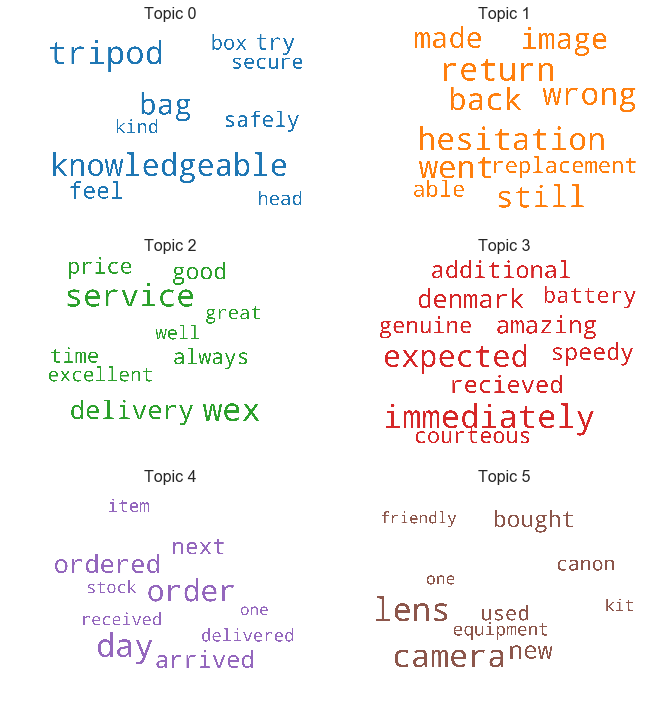

In [144]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

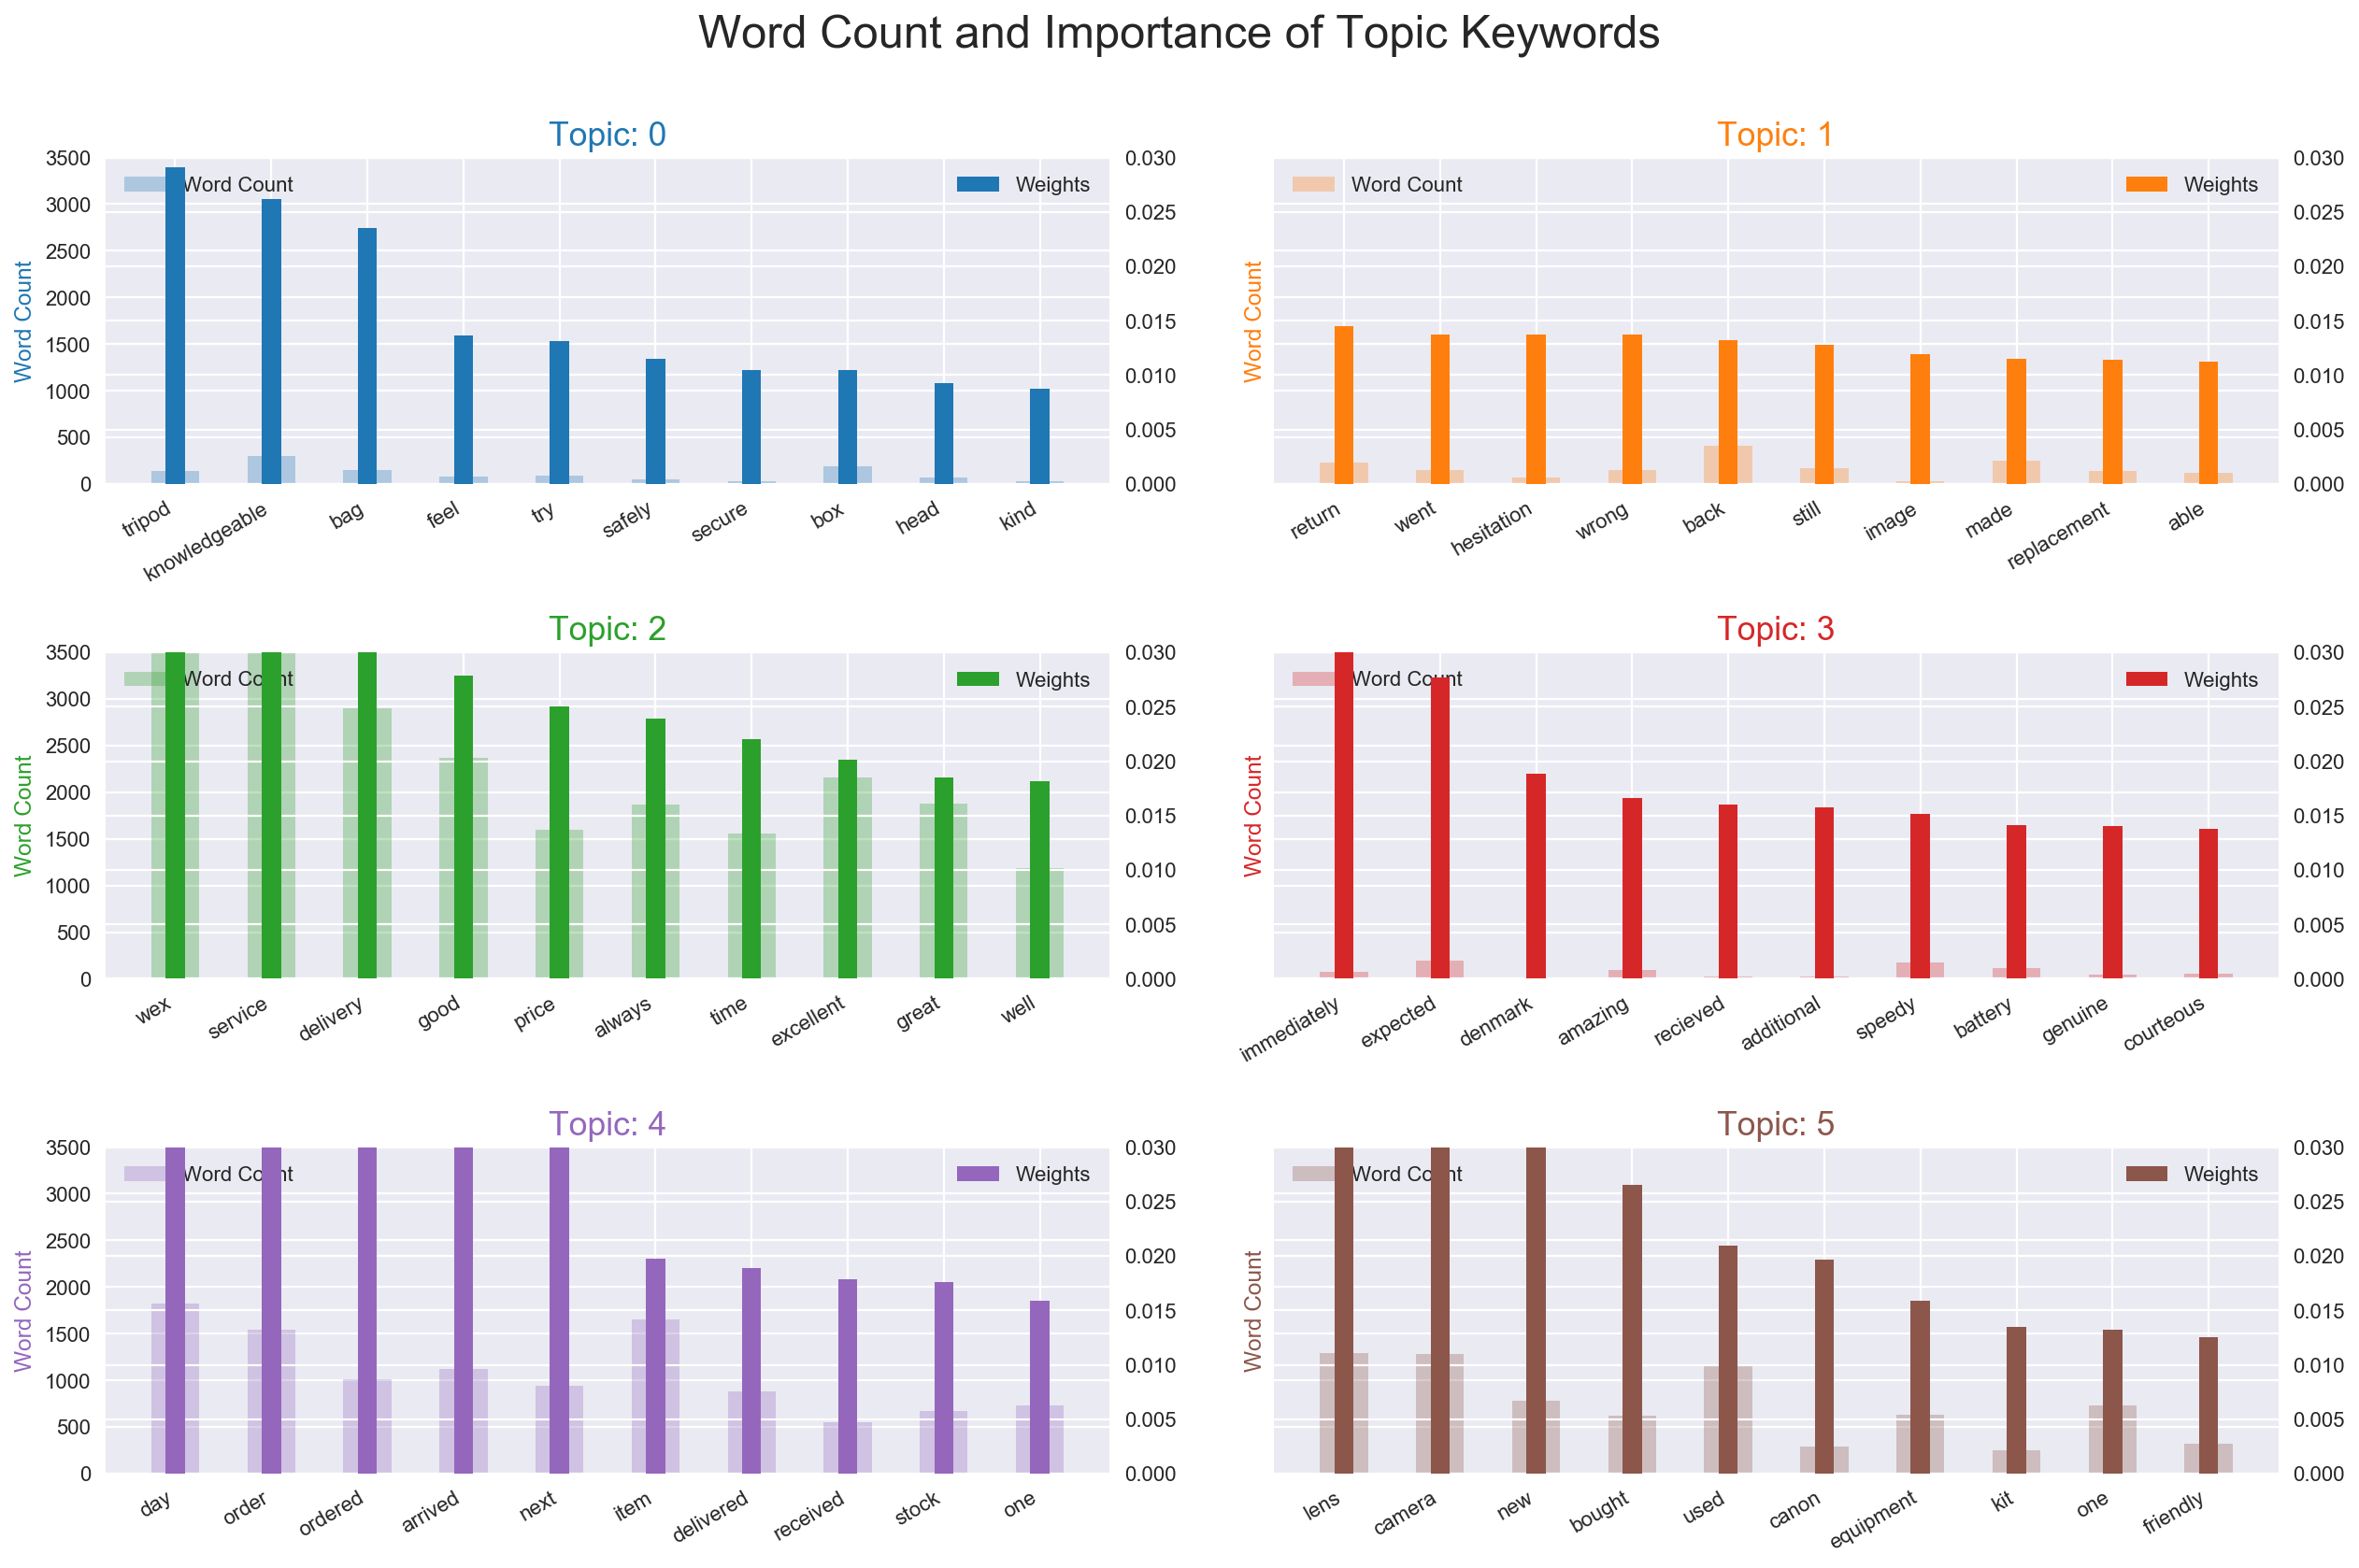

In [145]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [7]:
model_sim = gensim.models.Word2Vec(sentences=data_lemmatized, min_count=2, hs=1)
print (model_sim.similar_by_word('service', 10)) 

[('sevice', 0.7680749893188477), ('usual', 0.7424015998840332), ('communication', 0.7252107262611389), ('servise', 0.7205898761749268), ('allways', 0.7131252288818359), ('highly_recommended', 0.7104359269142151), ('ensures', 0.7062363624572754), ('support', 0.7061700820922852), ('faultless', 0.7006598711013794), ('thoroughly_recommended', 0.6988774538040161)]


In [81]:
def sentences_with(word):
    for sent in data['reviews']:
        if word in sent.split():
            return sent

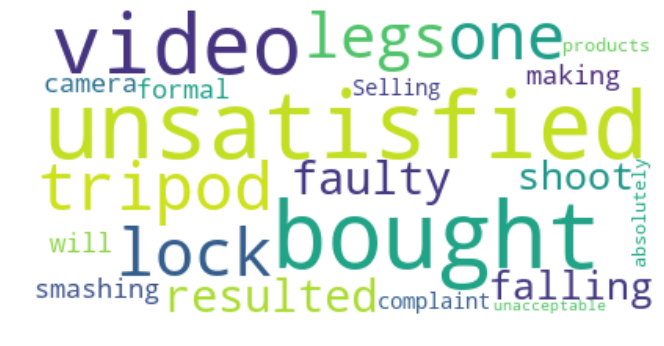

In [139]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
sents_with_word = sentences_with('complaint')
# Create and generate a word cloud image:
wordcloud = WordCloud(background_color="white").generate(sents_with_word)

# Display the generated image:
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [106]:
df_topic_sents_keywords.groupby('Dominant_Topic').count()

,Perc_Contribution,Topic_Keywords,0
Dominant_Topic,,,
0.0,19,19,19
1.0,3037,3037,3037
2.0,4851,4851,4851
3.0,17,17,17
4.0,758,758,758
5.0,137,137,137


In [38]:
# tensorflow something

words = list(set([item for sublist in data_lemmatized for item in sublist]))
vocab_size = len(flat_list)
word2int = {}
int2word = {}
vocab_size = len(flat_list) # gives the total number of unique words
for i,word in enumerate(words):
    word2int[word] = i
    int2word[i] = word

In [49]:
wordsid = []
for sent in data_lemmatized:
    wordsid_s = []
    for word in sent:
        wordsid_s.append(word2int[word])
    wordsid.append(wordsid_s)

In [33]:
word_embeddings = tf.get_variable("word_embeddings",[vocab_size, 100])

In [55]:
import itertools
dense_vectors = np.array(list(itertools.zip_longest(*wordsid, fillvalue=0))).T

In [60]:
embedded_word_ids = tf.nn.embedding_lookup(word_embeddings, dense_vectors)

In [62]:
embedded_word_ids

<tf.Tensor 'embedding_lookup_1:0' shape=(8819, 346, 100) dtype=float32>

In [29]:
print(data[0])

['tel', 'order']


In [25]:
??Word2Vec

In [66]:
model = Word2Vec(data_lemmatized,window=12, size=100, min_count=3)
word_vectors = model.wv

In [67]:
word_vectors.save("w2v_model")
fname = "w2v_model"

In [68]:
model = gensim.models.keyedvectors.KeyedVectors.load(fname)

In [69]:
max_size = len(model.wv.vocab)-1

In [70]:
w2v = np.zeros((max_size,model.wv.vector_size))

In [71]:
with open("metadata.tsv", 'w+') as file_metadata:
    for i,word in enumerate(model.wv.index2word[:max_size]):
        w2v[i] = model.wv[word]
        file_metadata.write(word + '\n')


In [72]:
w2v.tofile('wex.tsv')

In [73]:
w2v.tofile('wex.bytes')

In [15]:
sess = tf.InteractiveSession()

In [16]:
#Let us create a 2D tensor called embedding that holds our embeddings.
with tf.device("/cpu:0"):
    embedding = tf.Variable(w2v, trainable=False, name='embedding')

tf.global_variables_initializer().run()


In [17]:
path = 'tensorboard'
saver = tf.train.Saver()
writer = tf.summary.FileWriter(path, sess.graph)
config = projector.ProjectorConfig()
embed = config.embeddings.add()
embed.tensor_name = 'embedding'
embed.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(writer, config)
saver.save(sess, path+'/model.ckpt', global_step=max_size)

'tensorboard/model.ckpt-3022'